In [ ]:
#pip install typing-extensions==3.7.4.1

In [ ]:
!pip install webrtcvad
import contextlib
import numpy as np
import wave
import librosa
import webrtcvad


def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


class Frame(object):
  def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

In [ ]:
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(vad, frames, sample_rate):
    is_speech = []
    for frame in frames:
        is_speech.append(vad.is_speech(frame.bytes, sample_rate))
    return is_speech


def vad(file):
    audio, sample_rate = read_wave(file)
    vad = webrtcvad.Vad(2)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(vad, frames, sample_rate)
    return segments

In [ ]:
def speech(file):
  dummy = 0
  data = []
  segments = vad(file)
  audio, sr = librosa.load(file)
  for i in segments:
    if i == True:
      data.append(audio[dummy:dummy + 480])
      dummy = dummy + 480
    else:
      dummy = dummy + 480
  data = np.ravel(np.asarray(data))

  return data

def fxn(file):
  segments = vad(file)
  segments = np.asarray(segments)
  dummy = 0.01*np.where(segments[:-1] != segments[1:])[0] +.01
  if len(dummy)%2==0:
    dummy = dummy
  else:
    dummy = np.delete(dummy, len(dummy)-1)

  voice = dummy.reshape(int(len(dummy)/2),2)

  return voice

In [ ]:
!pip install tensorflow

In [ ]:
import warnings
warnings.filterwarnings("ignore")
file_list = ['Hindi_01', 'Hindi_02', 'Hindi_03']



def extract_feature(file_name):
    file = "/content/" + file_name + ".wav"
    frame_size = 2048
    frame_shift = 512
    y, sr = librosa.load(file)
    #MFCC Extraction
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=frame_shift, n_fft=frame_size)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfcc = mfccs[1:, ]
    norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
    norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
    norm_mfcc_delta2= (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

    ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))

 #Loading Annotation File
    ann = pd.read_csv('/content/hindi_annotations1.csv')
    ann['End_point'] = ann['Duration'] + ann['Offset']

    change_point = []
    for i in range(len(ann['End_point'])):
        dur_1 = int((ann['End_point'][i]-0.075)*sr)  # left 50ms
        dur_2 = int((ann['End_point'][i]+0.075)*sr)  # right 50ms
        change_point.append((dur_1, dur_2))

    sub_seq_len = int(3.2*sr/frame_shift)
    sub_seq_step= int(0.8*sr/frame_shift)

    feature_len = ac_feature.shape[1]

    def is_change_point(n):
        flag = False
        for x in change_point:
            if n > x[0] and n < x[1]:
                flag = True
                break

            if n+frame_size-1 > x[0] and n+frame_size-1 < x[1]:
                flag = True
                break
        return flag

    sub_train_x = []
    sub_train_y = []
    for i in range(0, feature_len-sub_seq_len, sub_seq_step):
        sub_seq_x = np.transpose(ac_feature[:, i: i+sub_seq_len])
        sub_train_x.append(sub_seq_x[np.newaxis, :, :])
        tmp = []
        for index in range(i, i+sub_seq_len):
            if is_change_point(index*frame_shift):
                tmp.append(1)
            else:
                tmp.append(0)
        lab_y = np.array(tmp)
        lab_y = np.reshape(lab_y, (1, sub_seq_len))
        sub_train_y.append(lab_y)
    return sub_train_x, sub_train_y


def load_dataset():
    all_x = []
    all_y = []
    for audio_file in file_list:
        new_train_x, new_train_y = extract_feature(audio_file)
        new_train_x = np.vstack(new_train_x)
        new_train_y = np.vstack(new_train_y)
        print(new_train_x.shape)
        print(new_train_y.shape)

        all_x.append(new_train_x)
        all_y.append(new_train_y)
    print(len(all_x))
    print(len(all_y))

    all_x_stack = np.vstack(all_x)
    all_y_stack = np.vstack(all_y)
    print(all_x_stack.shape, all_y_stack.shape)
    print('over')
    return all_x_stack, all_y_stack

In [ ]:
#from keras.legacy import interfaces
from keras.optimizers import Optimizer
from keras import backend as K
#SNORM Optimizer
#class SMORMS3(Optimizer):

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, TimeDistributed, BatchNormalization

In [ ]:
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense, BatchNormalization

In [ ]:
def train_bigru():
    input_shape = (137, 35)
    num_classes = 1
    model = Sequential()

    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second Bidirectional GRU layer
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third Bidirectional GRU layer (Optional: Add more layers for deeper networks)
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(137, activation='sigmoid' if num_classes == 1 else 'softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    all_x, all_y = load_dataset()
    print(all_y.shape, np.sum(all_y))

    subsample_all_x = []
    subsample_all_y = []
    for index in range(all_y.shape[0]):
        class_positive = sum(all_y[index])
        if class_positive > 5:
            subsample_all_x.append(all_x[index][np.newaxis, :, :])
            subsample_all_y.append(all_y[index])

    all_x = np.vstack(subsample_all_x)
    all_y = np.vstack(subsample_all_y)
    print(all_y.shape, np.sum(all_y))
    all_y = all_y[:, :, np.newaxis]

    indices = np.random.permutation(all_x.shape[0])
    all_x_random = all_x[indices]
    all_y_random = all_y[indices]

    datasize = all_x_random.shape[0]
    train_size = int(datasize*0.97)
    train_x = all_x_random[0:train_size]
    valid_x = all_x_random[train_size:]

    train_y = all_y_random[0:train_size]
    valid_y = all_y_random[train_size:]
    print('train over')

    my = model.fit(x=train_x, y=train_y, batch_size=256, epochs=50,
              validation_data=(valid_x, valid_y), shuffle=True)
    model.save('/content/model_hindi_2.h5')
    def save_model(model, json_model_file, h5_model_file):
        # serialize model to JSON
        model_json = model.to_json()
        with open(json_model_file, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights(h5_model_file)
        print("Saved model to disk")

    model_name = 'speech_seg1'
    #json_model_file = '/content/model_hindi_2'+'.json'
    #h5_model_file = '/content/model_hindi_2'+'.h5'
    #save_model(model, json_model_file, h5_model_file)

In [ ]:
import pandas as pd
train_bigru()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 137, 256)            │         126,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 137, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 137, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 137, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 137)                 │           8,905 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 566,537 (2.16 MB)

 Trainable params: 565,257 (2.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

(2305, 137, 35)
(2305, 137)
(2256, 137, 35)
(2256, 137)
(696, 137, 35)
(696, 137)
3
3
(5257, 137, 35) (5257, 137)
over
(5257, 137) 11892
(979, 137) 11643
train over
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.0017 - loss: 0.7700 - val_accuracy: 0.0000e+00 - val_loss: 0.6804
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.0000e+00 - loss: 0.6989 - val_accuracy: 0.0000e+00 - val_loss: 0.6660
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 9.8073e-04 - loss: 0.6464 - val_accuracy: 0.0000e+00 - val_loss: 0.6486
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.0000e+00 - loss: 0.5993 - val_accuracy: 0.0000e+00 - val_loss: 0.6268
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.0000e+00 - loss: 0.5602 - val_accuracy: 0.0000e+00 - val_loss: 0.6001
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.0017 - loss: 0.5215 - val_accuracy: 0.0000e+00 - val_loss: 0.5663
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - a

In [ ]:
import tensorflow
import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import *
from keras.models import *
import librosa
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Bidirectional, TimeDistributed, Dropout
from keras.layers import LSTM
import numpy as np
import keras

input_shape = (137, 35)
num_classes = 1
model = Sequential()

model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.3))

    # Second Bidirectional GRU layer
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

    # Third Bidirectional GRU layer (Optional: Add more layers for deeper networks)
model.add(Bidirectional(GRU(64, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

    # Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

    # Output layer
model.add(Dense(137, activation='sigmoid' if num_classes == 1 else 'softmax'))


model.build(input_shape=(None, 137, 35))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 137, 256)            │         126,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 137, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 137, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 137, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 137, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 137)                 │           8,905 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 566,537 (2.16 MB)

 Trainable params: 565,257 (2.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
model.load_weights("/content/model_hindi_2.h5")

In [ ]:
def multi_segmentation(file):
    frame_size = 2048
    frame_shift = 512
    y, sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=frame_shift, n_fft=frame_size)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    mfcc = mfccs[1:, ]
    norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
    norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
    norm_mfcc_delta2 = (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

    ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))
    print(ac_feature.shape)

    sub_seq_len = int(3.2 * sr / frame_shift)
    sub_seq_step = int(0.8 * sr / frame_shift)

    def extract_feature():
        feature_len = ac_feature.shape[1]
        sub_train_x = []
        for i in range(0, feature_len-sub_seq_len, sub_seq_step):
            sub_seq_x = np.transpose(ac_feature[:, i: i+sub_seq_len])
            sub_train_x.append(sub_seq_x[np.newaxis, :, :])
        return np.vstack(sub_train_x), feature_len

    predict_x, feature_len = extract_feature()
    print(predict_x.shape)

    predict_y = model.predict(predict_x)
    print(predict_y.shape)

    score_acc = np.zeros((feature_len, 1))
    score_cnt = np.ones((feature_len, 1))

    for i in range(predict_y.shape[0]):
        for j in range(predict_y.shape[1]):
            index = i*sub_seq_step+j
            score_acc[index] += predict_y[i, j]
            score_cnt[index] += 1

    score_norm = score_acc / score_cnt

    wStart = 0
    wEnd = 200
    wGrow = 200
    delta = 25

    store_cp = []
    index = 0
    while wEnd < feature_len:
        score_seg = score_norm[wStart:wEnd]
        max_v = np.max(score_seg)
        max_index = np.argmax(score_seg)
        index = index + 1
        if max_v > 0.5:
            temp = wStart + max_index
            store_cp.append(temp)
            wStart = wStart + max_index + 50
            wEnd = wStart + wGrow
        else:
            wEnd = wEnd + wGrow

    seg_point = np.array(store_cp)*frame_shift

    plt.figure('speech segmentation plot')
    plt.plot(np.arange(0, len(y)) / (float)(sr), y, "b-")

    for i in range(len(seg_point)):
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="c", linestyles="dashed")
        plt.vlines(seg_point[i] / (float)(sr), -1, 1, colors="r", linestyles="dashed")
    plt.xlabel("Time/s")
    plt.ylabel("Speech Amp")
    plt.grid(True)
    plt.show()

    return np.asarray(seg_point) / float(sr)

In [ ]:
def group_intervals(a):
    a = a.tolist()
    ans = []

    curr = None
    for x in a:
        # no previous interval under consideration
        if curr == None:
          curr = x
        else:
            # check if we can merge the intervals
            if x[0]-curr[1] < 1:
                curr[1] = x[1]
            else:
            # if we cannot merge, push the current element to ans
                ans.append(curr)
                curr = x

        if curr is not None:
            ans.append(curr)

    d1 = np.asarray(ans)
    d2 = np.unique(d1)
    d3 = d2.reshape(int(len(d2)/2),2)
    return d3

In [ ]:
def spliting(seg,arr):
  arr1 = arr.tolist()
  temp = arr.copy()

  for i in range(len(seg)-1):
    temp1 = float(seg[i])
    # print(temp1)
    #for j in range(len(arr)-1):
    for j in range(len(arr)):
      if ((temp1 > arr[j][0]) & (temp1 < arr[j][1])):
        arr1[j].insert(-1,(temp1))

  #for i in range(len(arr1-1)):
  for i in range(len(arr1)):
    size=len(arr1[i])
    if size>=3:
      arr1[i].pop(-2) if arr1[i][-1]-arr1[i][-2]<0.2 else True

  return arr1

In [ ]:
def final_reseg(arr):
  z=[]
  for i in arr:
    if len(i)==2:
      z.append(i)
    else:
      temp = len(i)
      for j in range(temp-1):
        if j!=temp-1:
          temp1 = [i[j],i[j+1]-0.01]
          z.append(temp1)
        elif j==temp-1:
          temp1 = [i[j],i[j+1]]
          z.append(temp1)

  return np.asarray(z)

In [ ]:
!pip install pyannote.core==4.1 pyannote.pipeline==1.5.2 pyannote.audio==1.1.1
!wget -nc https://raw.githubusercontent.com/pyannote/pyannote-audio/1.1.1/hubconf.py -P /root/.cache/torch/hub/pyannote_pyannote-audio_main
import torch
import pyannote.core #https://github.com/pyannote/pyannote-audio/issues/561

File ‘/root/.cache/torch/hub/pyannote_pyannote-audio_main/hubconf.py’ already there; not retrieving.



In [ ]:
import torch
import librosa
from pyannote.core import Segment

def embeddings_(audio_path,resegmented,range):
  model_emb = torch.hub.load('pyannote/pyannote-audio', 'emb')

  embedding = model_emb({'audio': audio_path})
  for window, emb in embedding:
    assert isinstance(window, Segment)
    assert isinstance(emb, np.ndarray)

  y, sr = librosa.load(audio_path)
  myDict={}
  myDict['audio'] = audio_path
  myDict['duration'] = len(y)/sr

  data=[]
  for i in resegmented:
    excerpt = Segment(start=i[0], end=i[0]+range)
    emb = model_emb.crop(myDict,excerpt)
    data.append(emb.T)
  data= np.asarray(data)

  return data.reshape(len(data),512)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
scaler = StandardScaler()
def clustering(emb):
  temp = scaler.fit_transform(emb)
  Y = TSNE(n_components=2).fit_transform(temp)
  cluster_ms = MeanShift(bandwidth = 3,max_iter=200,cluster_all=False).fit(Y)
  y_ms = cluster_ms.predict(Y)
  clus_centre = cluster_ms.cluster_centers_
  n_speakers = clus_centre.shape[0]
  plt.figure
  plt.scatter(Y[:,0], Y[:, 1], c=y_ms, s=50, cmap='viridis')
  plt.show()

  return y_ms, n_speakers

In [ ]:
from pyannote.core import Annotation, Segment
def hypothesis_gen(hyp_df):
  hyp_records = hyp_df.to_records(index=False)
  hyp_rec = list(hyp_records)
  hypothesis = Annotation()
  for i in range(len(hyp_rec)-1):
    hypothesis[Segment(hyp_rec[i][1], hyp_rec[i][2])] = hyp_rec[i][0]

  return hypothesis

In [ ]:
from sklearn import preprocessing
import pandas as pd
def diarization(audiofile):
    voice = fxn(audiofile)
    segmented = multi_segmentation(audiofile)
    gp = group_intervals(voice)
    splt = spliting(segmented,gp)
    resegmented = final_reseg(splt)
    embeddings = embeddings_(audiofile,resegmented,2)
    speak_id , n_speakers = clustering(embeddings)
    label_list = []
    alpha = 'A'
    for i in range(0, n_speakers):
        label_list.append(alpha)
        alpha = chr(ord(alpha) + 1)
    lb = preprocessing.LabelEncoder()
    label_hyp = lb.fit(label_list)
    speaker_id = lb.inverse_transform(speak_id)
    hyp_df = pd.DataFrame({'Speaker_id': speaker_id,'Offset': resegmented[:, 0], 'end': resegmented[:, 1]})
    result_hypo = hypothesis_gen(hyp_df)
    return segmented, n_speakers, hyp_df, result_hypo

In [ ]:
!ffmpeg -n -i Hindi1_02.wav -ac 1 mono_hindi2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!ffmpeg -i mono_hindi2.wav -ar 16000 hindi2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
#!pip install librosa --upgrade

In [ ]:
!pip install pyannote.audio.features

ERROR: Could not find a version that satisfies the requirement pyannote.audio.features (from versions: none)
ERROR: No matching distribution found for pyannote.audio.features


(35, 51912)
(1523, 137, 35)
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step
(1523, 137)


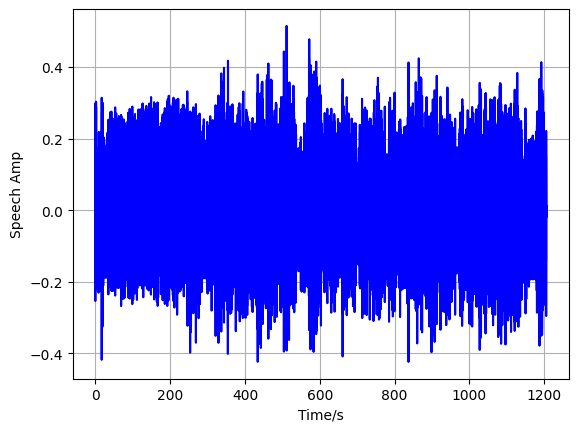

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


100%|██████████| 901/901 [00:00<00:00, 467kB/s]


100%|██████████| 16.3M/16.3M [00:00<00:00, 93.1MB/s]


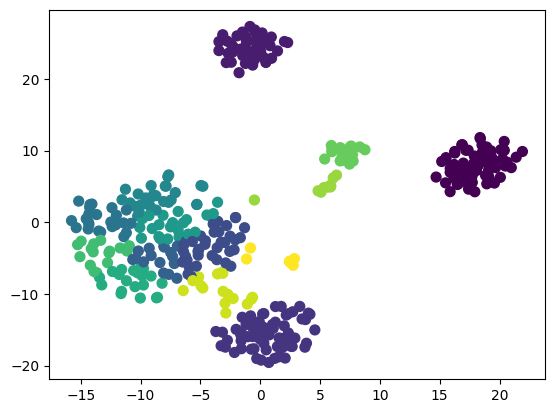

14
    Speaker_id   Offset      end
0            N     0.26     7.53
1            B    15.55    15.56
2            B    19.45    19.69
3            B    22.87    24.74
4            B    26.78    26.94
..         ...      ...      ...
383          G  1192.01  1192.12
384          E  1193.73  1193.99
385          H  1195.24  1195.30
386          J  1197.84  1198.13
387          F  1203.38  1203.60

[388 rows x 3 columns]


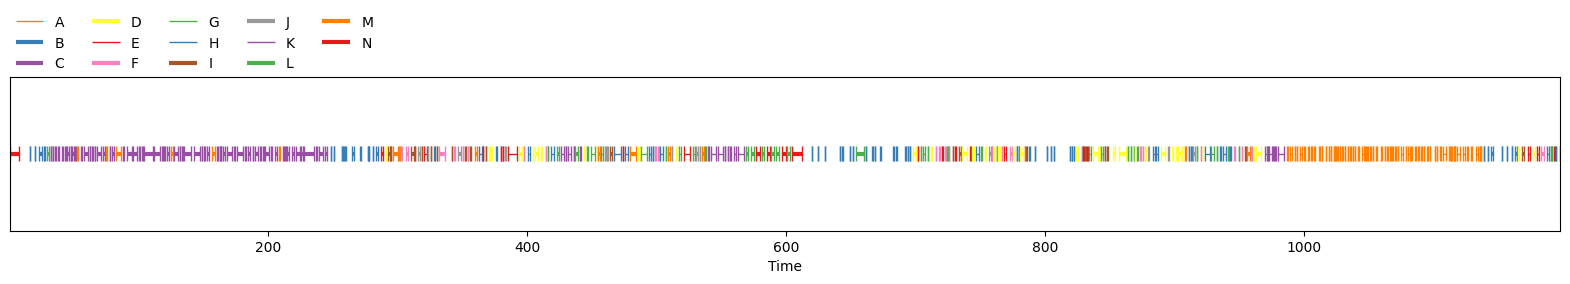

In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi2.wav")
print(n_clusters)
print(hyp_df)
result_hypo

In [ ]:
def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_02']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

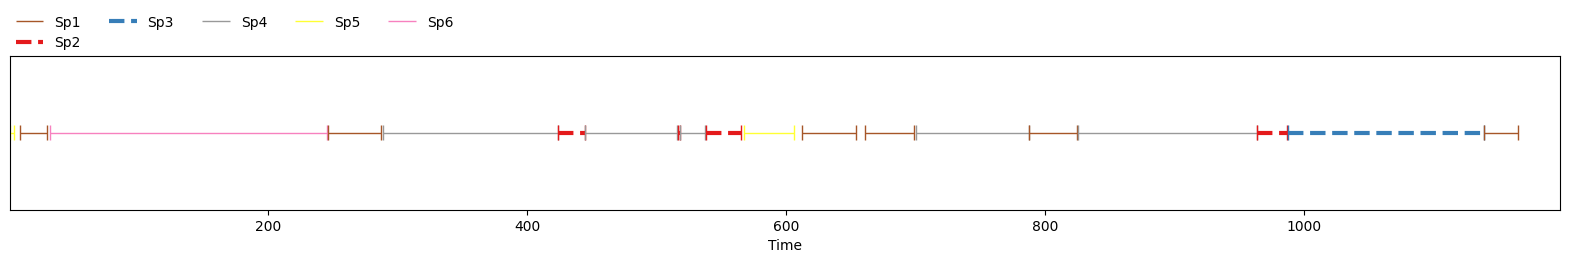

In [ ]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

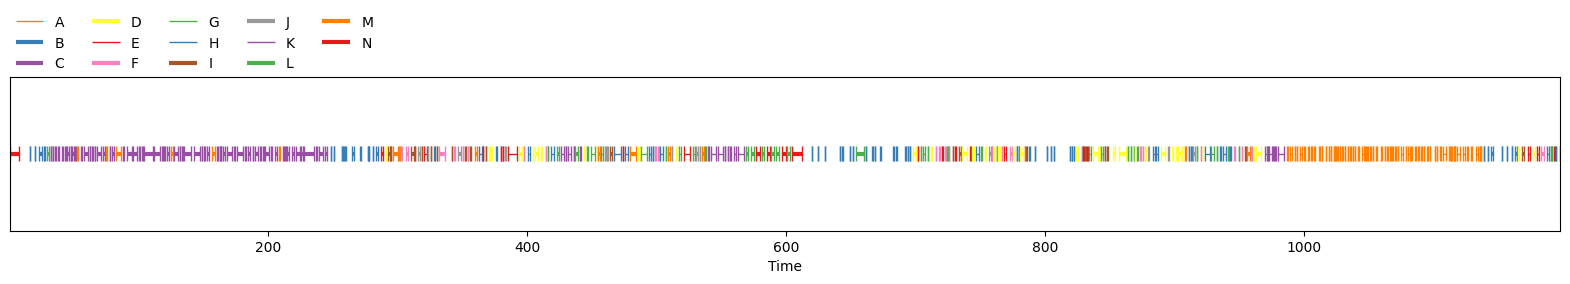

In [ ]:
result_hypo

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.827
Purity = 1.000
Coverage = 0.977


In [ ]:
!ffmpeg -n -i Hindi1_03.wav -ac 1 mono_hindi3.wav
!ffmpeg -i mono_hindi3.wav -ar 16000 hindi3.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 55990)
(1643, 137, 35)
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step
(1643, 137)


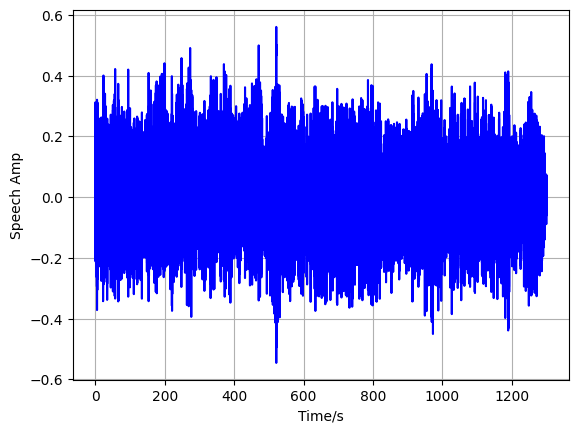

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


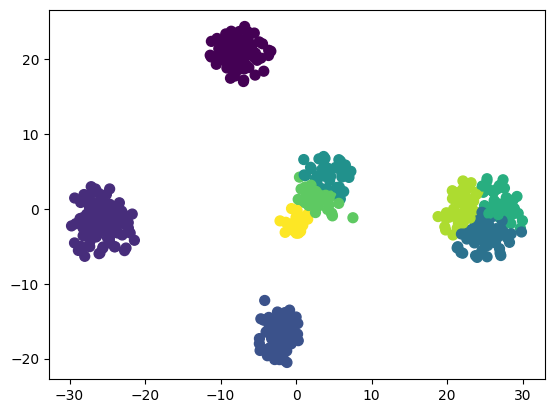

9
    Speaker_id   Offset      end
0            D     0.07     1.36
1            H     3.43     3.71
2            F     5.13     5.24
3            F     8.12     8.52
4            H    12.90    14.07
..         ...      ...      ...
430          C  1278.85  1278.89
431          C  1280.75  1281.01
432          C  1282.33  1282.46
433          C  1283.50  1283.68
434          A  1290.68  1299.42

[435 rows x 3 columns]


In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi3.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_03']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

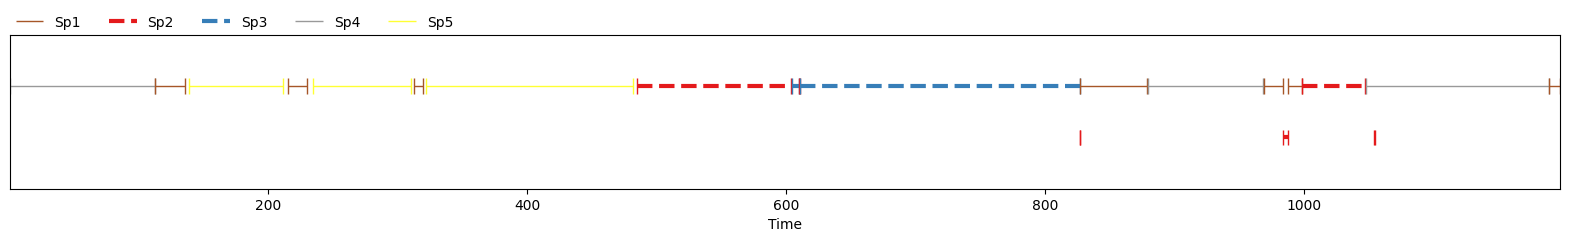

In [ ]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference
##meta heurisstics working and techniques, current sota
##cancer detection
##meta heuristics current sota, criticial analysis (current limitations and scope)
##explainable solutions to cancer detection current sota


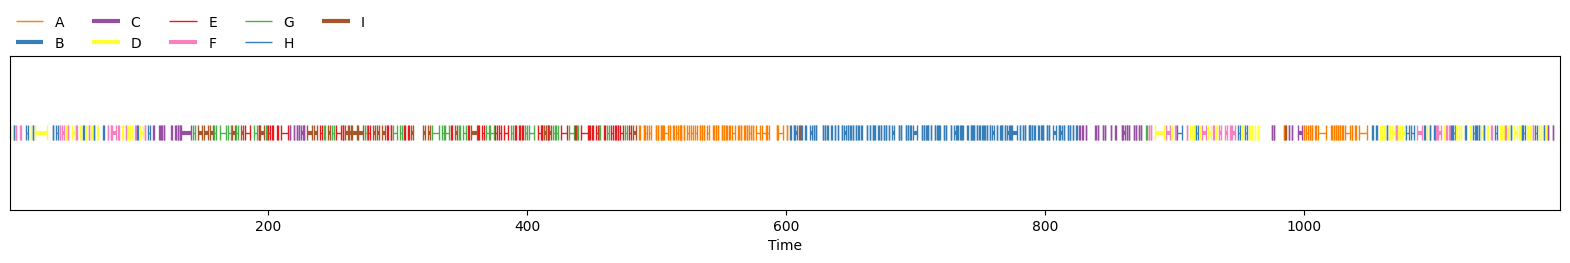

In [ ]:
result_hypo

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.827
Purity = 1.000
Coverage = 0.742


In [ ]:
!ffmpeg -n -i Hindi1_01.wav -ac 1 mono_hindi1.wav
!ffmpeg -i mono_hindi1.wav -ar 16000 hindi1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 51912)
(1523, 137, 35)
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step
(1523, 137)


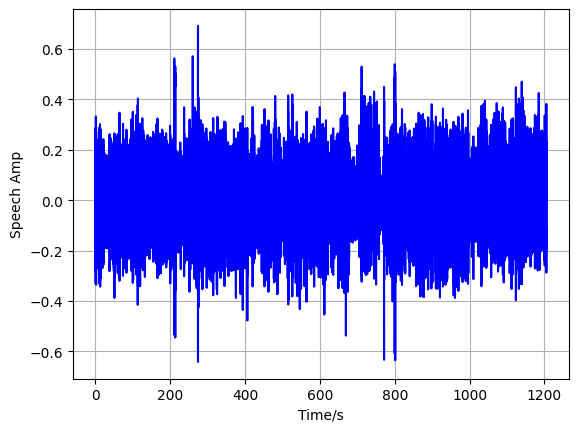

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


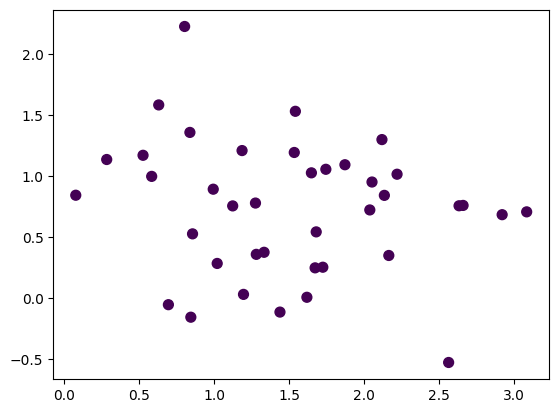

1
   Speaker_id   Offset      end
0           A     0.04   610.31
1           A   611.34   695.74
2           A   696.94   697.10
3           A   699.68   709.23
4           A   710.85   712.28
5           A   713.35   725.12
6           A   726.40   728.72
7           A   730.08   740.09
8           A   741.16   750.98
9           A   752.03   756.64
10          A   757.68   760.95
11          A   762.35   762.42
12          A   763.52  1013.19
13          A  1016.08  1018.20
14          A  1019.83  1021.23
15          A  1022.33  1023.99
16          A  1025.93  1027.57
17          A  1029.14  1033.26
18          A  1034.82  1047.38
19          A  1048.48  1051.69
20          A  1052.90  1056.17
21          A  1057.45  1058.44
22          A  1059.44  1064.95
23          A  1066.27  1074.25
24          A  1075.88  1090.12
25          A  1091.34  1122.37
26          A  1123.87  1125.65
27          A  1127.21  1132.56
28          A  1134.12  1136.27
29          A  1138.51  1148.69
30    

In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindi1.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi1_01']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

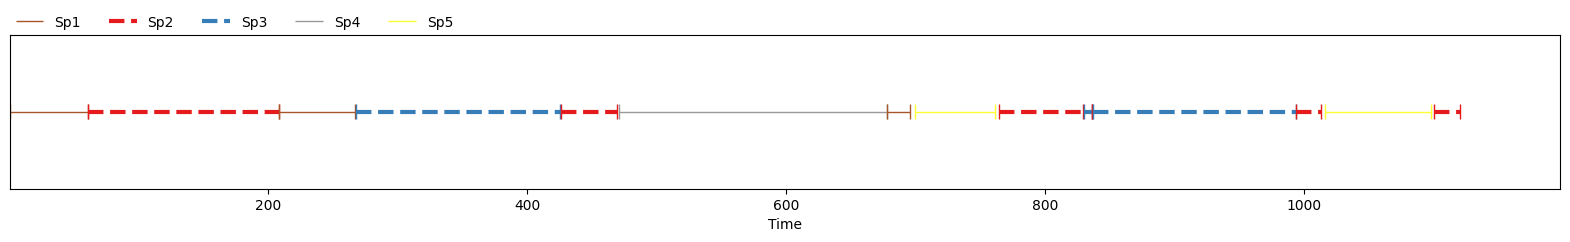

In [ ]:
reference, ref_df = reference_gen('/content/annotations1 (1).csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

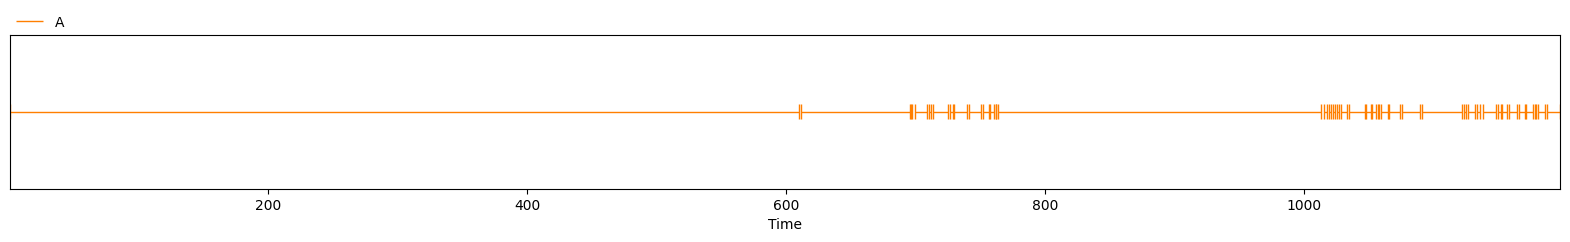

In [ ]:
result_hypo

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage

In [ ]:

#Upload the annotation file from Google Drive. Change the Path accordingly.
result_ref, ref_df = reference_gen('/content/annotations1 (1).csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.773
Purity = 1.000
Coverage = 1.000


In [ ]:
!ffmpeg -n -i Hindi_01.wav -ac 1 mono_hindiA1.wav
!ffmpeg -i mono_hindiA1.wav -ar 16000 hindiA1.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 78497)
(2305, 137, 35)
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step
(2305, 137)


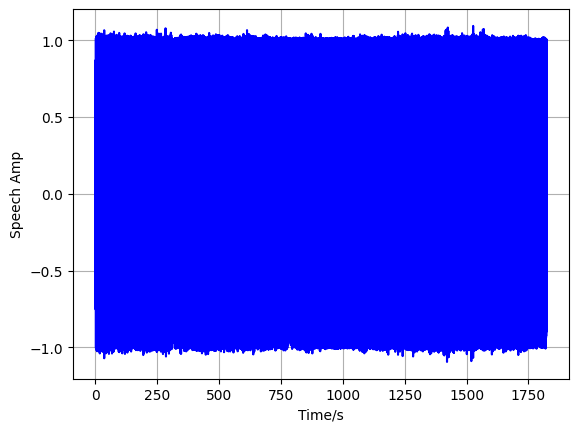

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


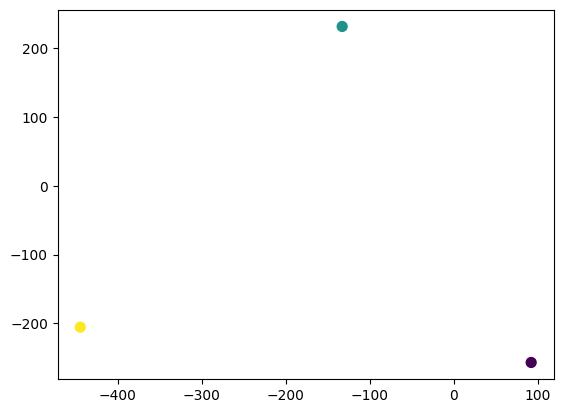

3
  Speaker_id   Offset      end
0          B     0.05   294.75
1          C   296.30  1029.57
2          A  1030.91  1821.23


In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA1.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_01']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

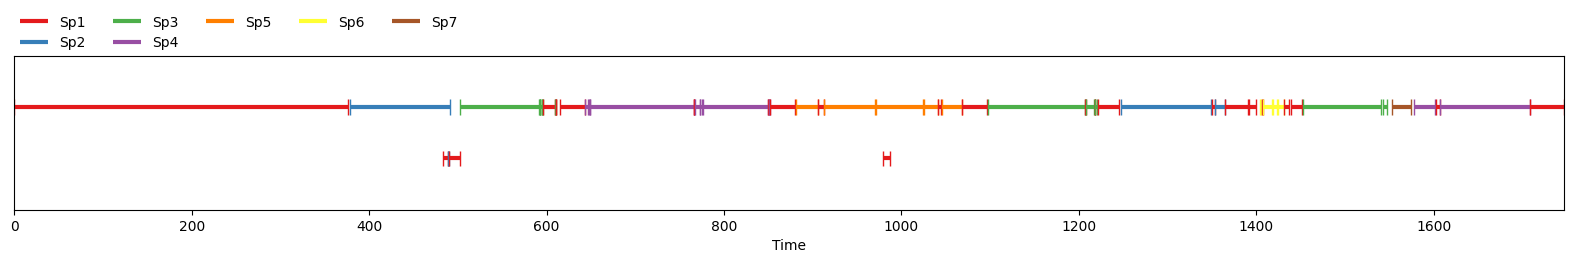

In [ ]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

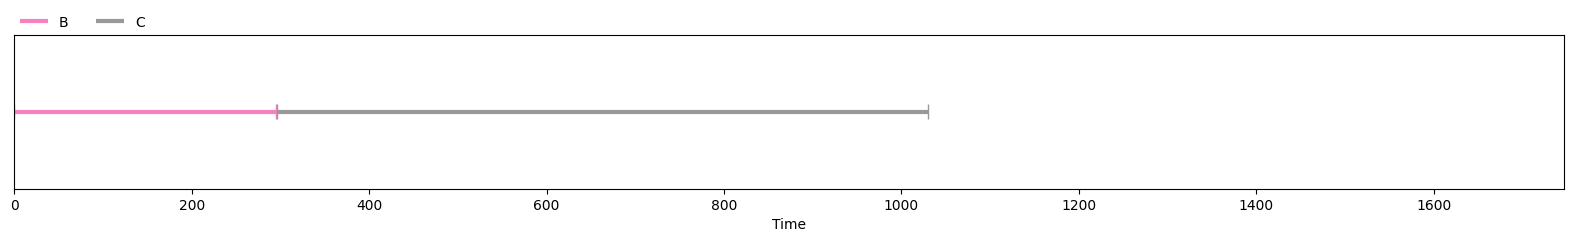

In [ ]:
result_hypo

In [ ]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.720
Purity = 1.000
Coverage = 1.000


In [ ]:
!ffmpeg -n -i Hindi_02.wav -ac 1 mono_hindiA2.wav
!ffmpeg -i mono_hindiA2.wav -ar 16000 hindiA2.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 76817)
(2256, 137, 35)
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step
(2256, 137)


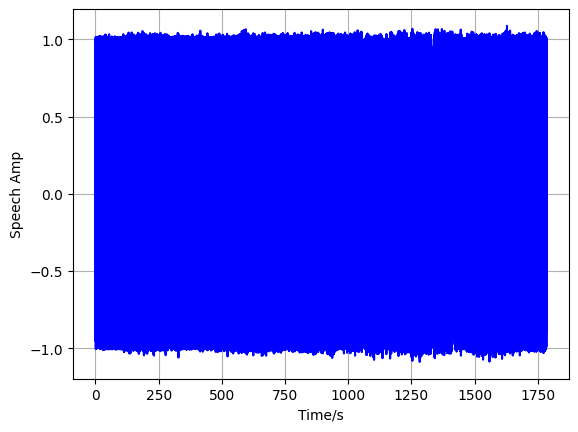

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


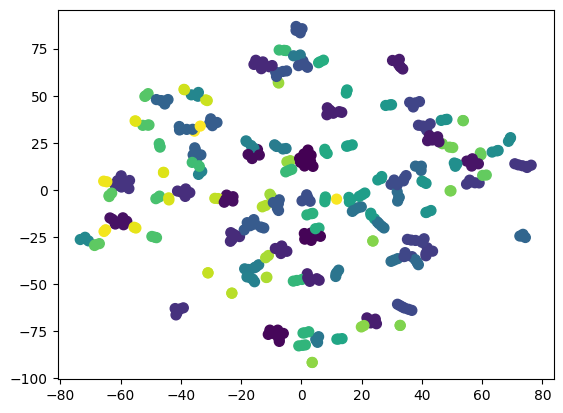

114
    Speaker_id   Offset      end
0            k     2.74     2.83
1            W     5.22     5.33
2                 6.65     8.08
3            k    11.80    12.32
4                 15.10    18.25
..         ...      ...      ...
441          \  1768.98  1769.99
442          L  1773.04  1773.05
443          \  1775.27  1775.31
444          T  1776.33  1776.49
445          O  1783.06  1783.11

[446 rows x 3 columns]


In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA2.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_02']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

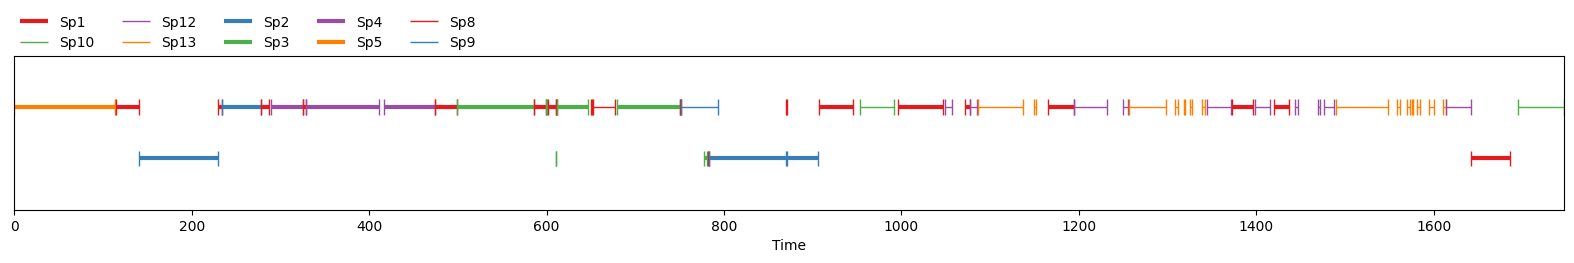

In [ ]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

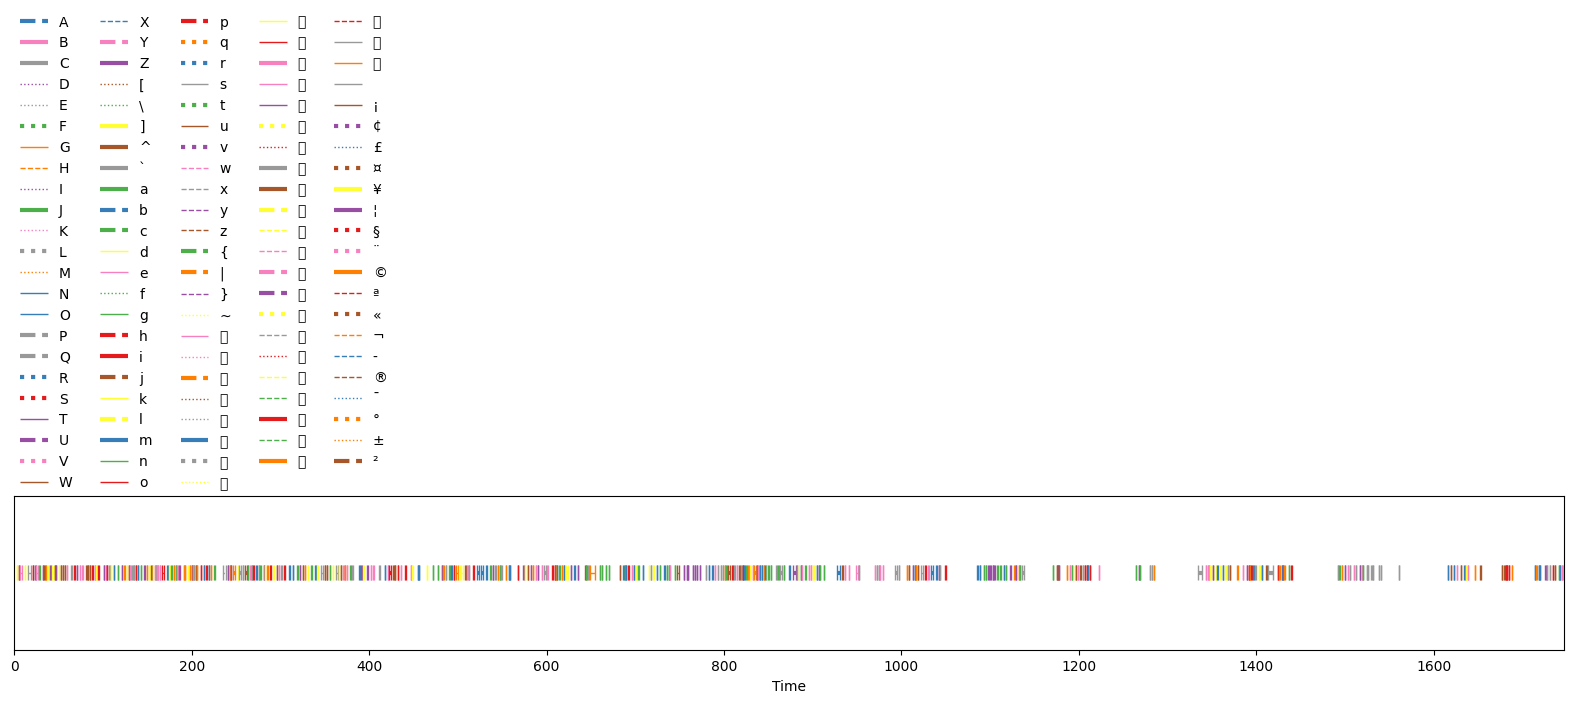

In [ ]:
result_hypo

In [ ]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 0.991
Purity = 1.000
Coverage = 0.294


In [ ]:
!ffmpeg -n -i Hindi_03.wav -ac 1 mono_hindiA3.wav
!ffmpeg -i mono_hindiA3.wav -ar 16000 hindiA3.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(35, 23788)
(696, 137, 35)
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step
(696, 137)


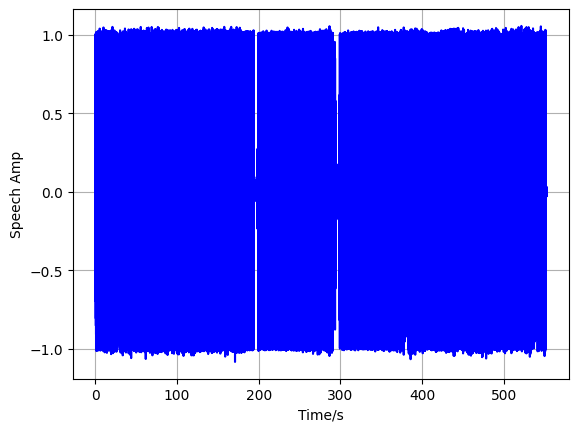

Using cache found in /root/.cache/torch/hub/pyannote_pyannote-audio_main


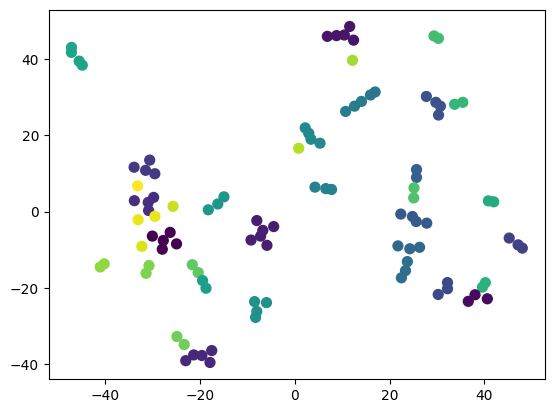

37
    Speaker_id  Offset     end
0            W    0.07    0.25
1            H    3.11    4.70
2            M    7.87   10.93
3            I   14.70   14.88
4            N   18.38   18.86
..         ...     ...     ...
99           X  402.58  402.88
100          N  544.70  545.12
101          N  547.62  547.98
102          I  549.45  549.93
103          V  551.71  551.79

[104 rows x 3 columns]


In [ ]:
segmented, n_clusters, hyp_df, result_hypo = diarization("hindiA3.wav")
print(n_clusters)
print(hyp_df)
result_hypo

def reference_gen(annotation_path):
  df = pd.read_csv(annotation_path)
  ref_df = df[df['filename'] == 'Hindi_03']
  ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
  ref_df = ref_df[['Speaker_id','Offset','end']]
  ref_records = ref_df.to_records(index=False)
  ref_rec = list(ref_records)
  reference = Annotation()
  for i in range(len(ref_rec)-1):
    reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

  return reference, ref_df

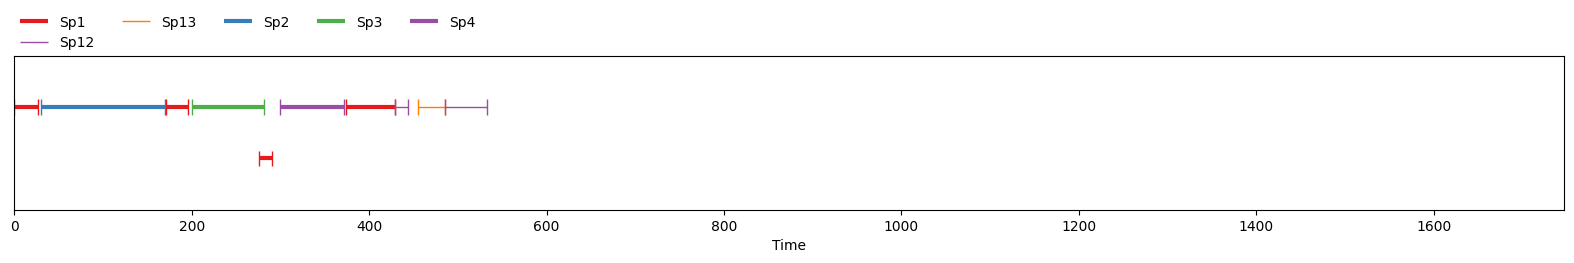

In [ ]:
reference, ref_df = reference_gen('/content/hindi_annotations1.csv')
#Visualization (Comparing Between Ground Truth and Hypothesis)
reference

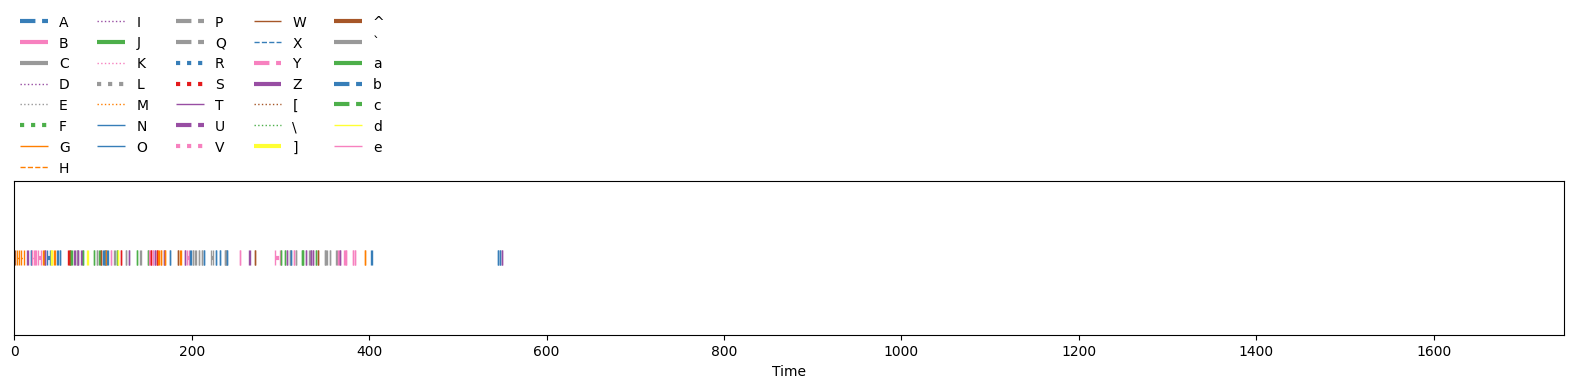

In [ ]:
result_hypo

In [ ]:
result_ref, ref_df = reference_gen('/content/hindi_annotations1.csv')
diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(result_ref, result_hypo)))
#To Evaluate particular Segment of audio-file.
diarizationErrorRate(result_ref, result_hypo, detailed=True, uem=Segment(0, 40))
#Purity
purity = DiarizationPurity()
print("Purity = {0:.3f}".format(purity(result_ref, result_hypo, uem=Segment(0, 40))))
#Coverage
coverage = DiarizationCoverage()
print("Coverage = {0:.3f}".format(coverage(result_ref, result_hypo, uem=Segment(0, 40))))

DER = 1.001
Purity = 1.000
Coverage = 0.481
